In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cptsolver.fields import *
from cptsolver.utils import *
from cptsolver.plot import *
from cptsolver.integrators import *
from cptsolver.solver import *
from cptsolver.analyzer import *
from cptsolver.young import *

from matplotlib import pyplot as plt

from datetime import datetime

We begin by grabbing the Tsyganenko model parameters from the dataset developed by Qin et al. (2007).

In [3]:
year = 2008
month = 3
day = 26
hour = 11
minute = 19

time = datetime(year, month, day, hour, minute)
parmod, ut, v_sw = get_txx_params('data/qindenton_03-26-2008', 'data/omni_03-26-2008', time)
b_field = t04(parmod, ut, v_sw)

Load IGRF coefficients ...


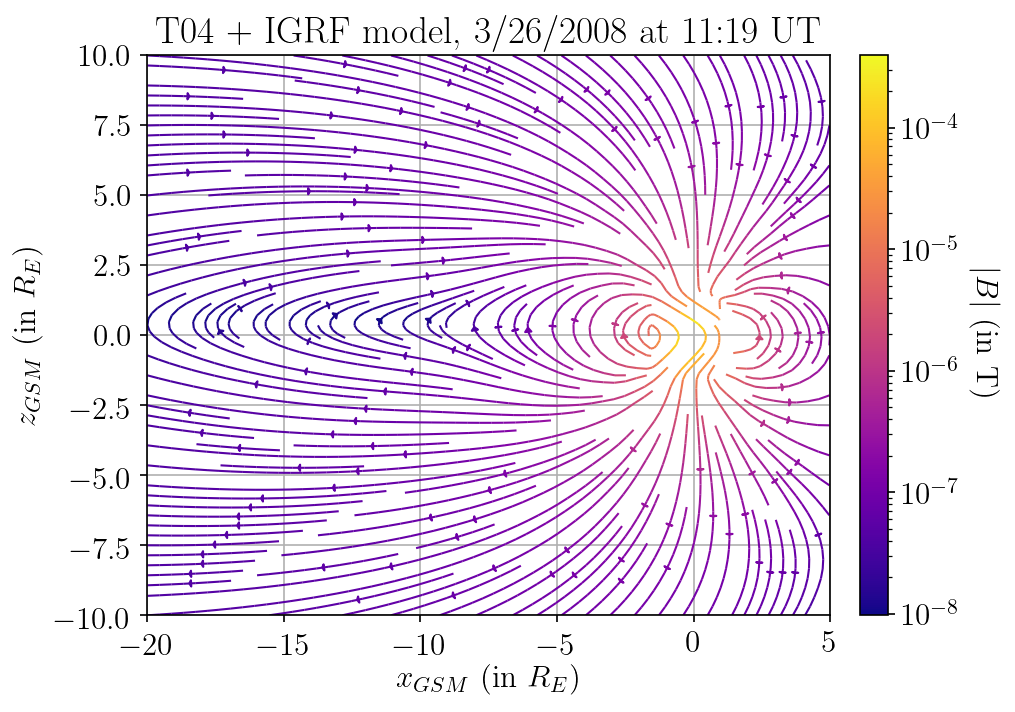

In [4]:
format_plots()
plot_field(b_field, np.array([1., 0., 0.]), np.array([0., 0., 1.]), [-20, 5], [-10, 10], size=(7, 5), labels=('$x_{GSM}$ (in $R_E$)', '$z_{GSM}$ (in $R_E$)', '$|B|$ (in T)'), title=f'T04 + IGRF model, {month}/{day}/{year} at {hour}:{minute} UT')

We next trace a field line at the specificed $L$ value along the midnight plane. After determining $\mathbf{B}$ along the field line, we calculate the $B_{\text{mirror}}$ and $B_0$.

In [6]:
L = 10

rr = field_line(b_field, np.array([-L * Re, 0., 0.]))
bv, bm, brm = b_along_path(b_field, rr)
cs_ind = bm.argmin()

b_mirror_south = bm[np.abs(np.linalg.norm(rr[0:cs_ind], axis=1) - (Re + 100e3)).argmin()]
b_mirror_north = bm[np.abs(np.linalg.norm(rr[cs_ind:], axis=1) - (Re + 100e3)).argmin() + cs_ind]

b0 = bm[cs_ind]
b_mirror = min(b_mirror_north, b_mirror_south)

eq_loss_cone_ang = np.arcsin(np.sqrt(bm[cs_ind] / b_mirror))
print(f'The equatorial loss cone angle is {np.degrees(eq_loss_cone_ang):.3f} degrees.')

The equatorial loss cone angle is 0.701 degrees.


We can compare the normalized bounce time between the Tsyganenko model and the usual expression valid in a dipole field.

In [7]:
T_alpha = normalized_bounce_time(b_field, 10)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


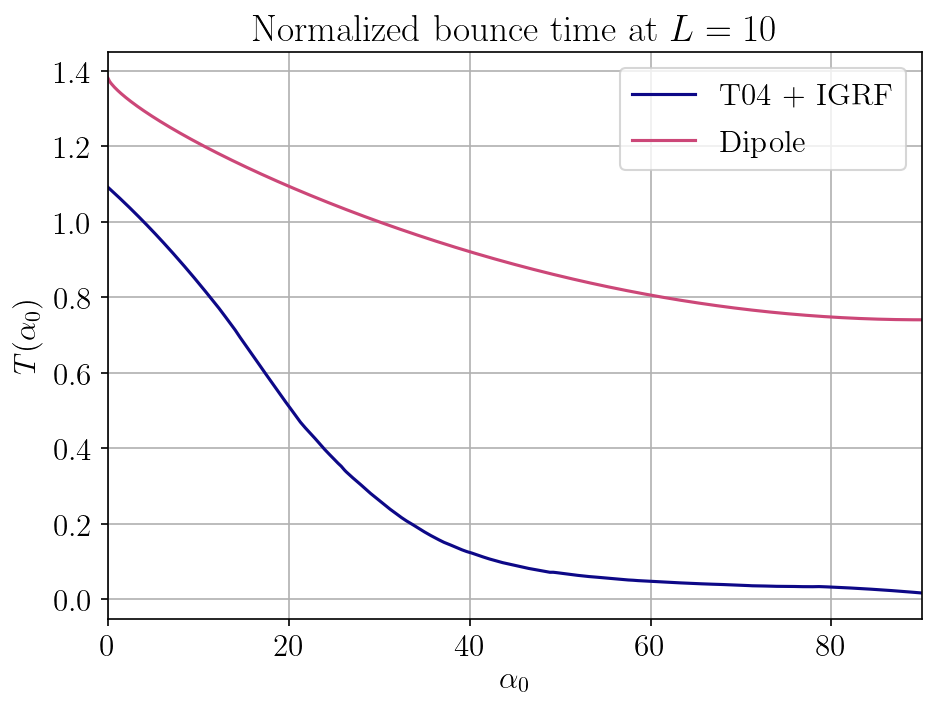

In [8]:
plt.figure(figsize=(7, 5))

alpha_eqs = np.radians(np.linspace(0, 90, 500))
plt.plot(np.degrees(alpha_eqs), T_alpha(alpha_eqs), label='T04 + IGRF')
plt.plot(np.degrees(alpha_eqs), T_dipole(alpha_eqs), label='Dipole', c='C7')

plt.xlim([0, 90])
plt.xlabel(r'$\alpha_0$')
plt.ylabel(r'$T(\alpha_0)$')
plt.title('Normalized bounce time at $L = 10$')

plt.legend()
plt.grid()
plt.show()

By guessing at the current sheet thickness $L_{cs}$, we generate the Harris model corresponding to the above Tsyganenko model.

In [20]:
L_cs_guess = 0.14997789520846744 * Re
# L_cs_guess = 0.5 * Re

b0x, sigma, L_cs = harris_params_from_txx(b_field, 10, L_cs_guess)
b_field_h = harris_cs_model(b0x, sigma, L_cs)

We can then examine the properties of this model and compare them to the Tsyganenko.

In [21]:
zsT = (rr[:, 2] - rr[cs_ind, 2]) / Re
flcT = np.zeros(len(bm))

for i in range(len(flcT)):
    flcT[i] = flc(b_field, rr[i], eps=10) / Re
    
N = 200
zs = np.linspace(-2, 2, N)

bm0 = np.zeros(N)
bm1 = np.zeros(N)

flc0 = np.zeros(N)
flc1 = np.zeros(N)

for i in range(N):
    bm0[i] = np.linalg.norm(b_field_h(np.array([0., 0., zs[i] * Re])))
    flc0[i] = flc(b_field_h, np.array([0., 0., zs[i] * Re]), eps=10) / Re
    
bh_v = np.zeros((300, 3))
zs_h = np.linspace(-2, 2, 300)

for i in range(300):
    bh_v[i] = b_field_h(np.array([0., 0., zs_h[i] * Re]))

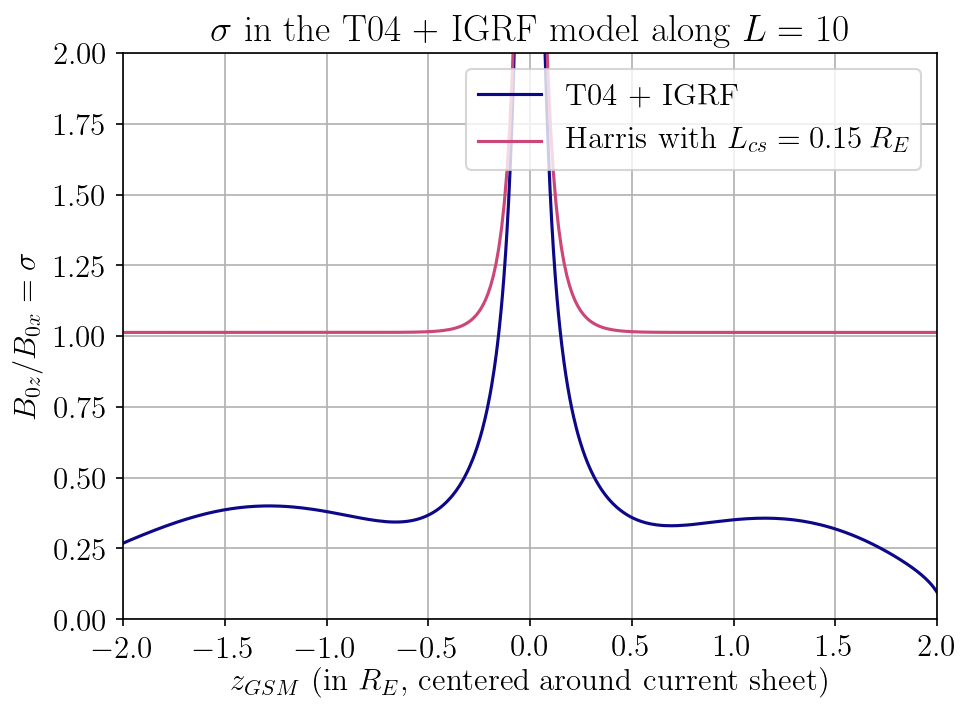

In [22]:
pad = 480
plt.figure(figsize=(7, 5))

plt.plot((rr[:, 2][pad:-pad] - rr[cs_ind, 2]) / Re, np.abs(bv[:, 2][pad:-pad] / bv[:, 0][pad:-pad]), label='T04 + IGRF')
plt.plot(zs_h, np.abs(bh_v[:, 2] / bh_v[:, 0]), c='C7', label=f'Harris with $L_{{cs}}={L_cs / Re:.2f}\,R_E$')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylim([0, 2])
plt.ylabel(r'$B_{0z}/B_{0x} = \sigma$')
plt.title(f'$\sigma$ in the T04 + IGRF model along $L = {L}$')

plt.legend()
plt.grid()
plt.show()

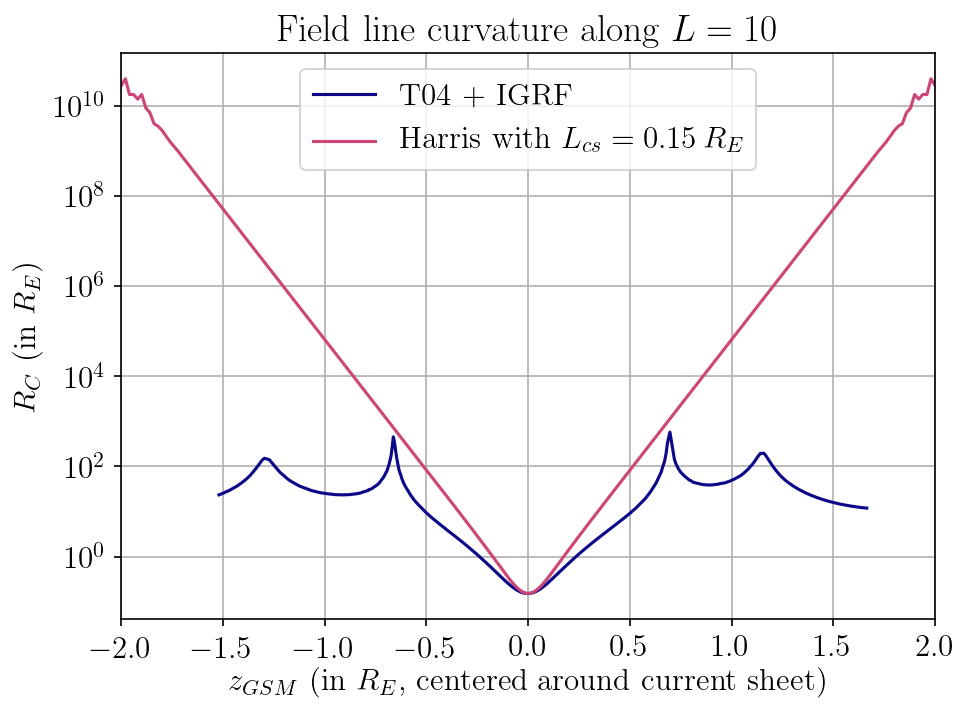

In [23]:
format_plots()
plt.figure(figsize=(7, 5))

plt.semilogy(zsT[cs_ind-200:cs_ind+200], flcT[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')    
plt.semilogy(zs, flc0, label=f'Harris with $L_{{cs}}={L_cs / Re:.2f}\,R_E$', c='C7')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylabel('$R_C$ (in $R_E$)')
plt.title(f'Field line curvature along $L={L}$')

plt.legend()
plt.grid()
plt.show()

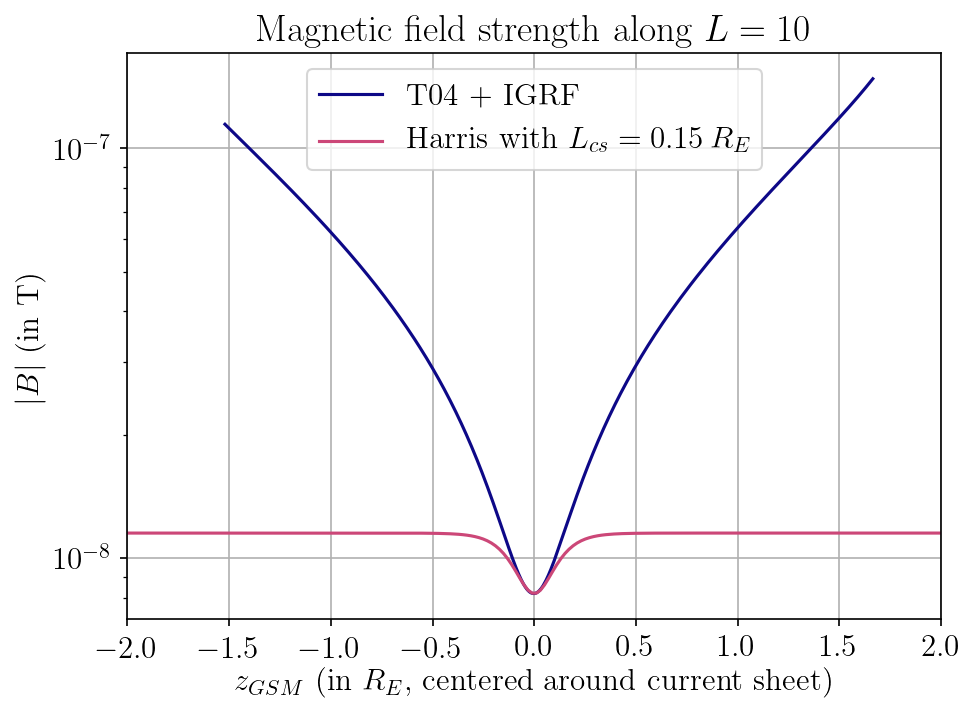

In [24]:
format_plots()
plt.figure(figsize=(7, 5))

plt.semilogy(zsT[cs_ind-200:cs_ind+200], bm[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')
plt.semilogy(zs, bm0, label=f'Harris with $L_{{cs}}={L_cs / Re:.2f}\,R_E$', c='C7')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylabel('$|B|$ (in T)')
plt.title(f'Magnetic field strength along $L={L}$')

plt.legend()
plt.grid()
plt.show()

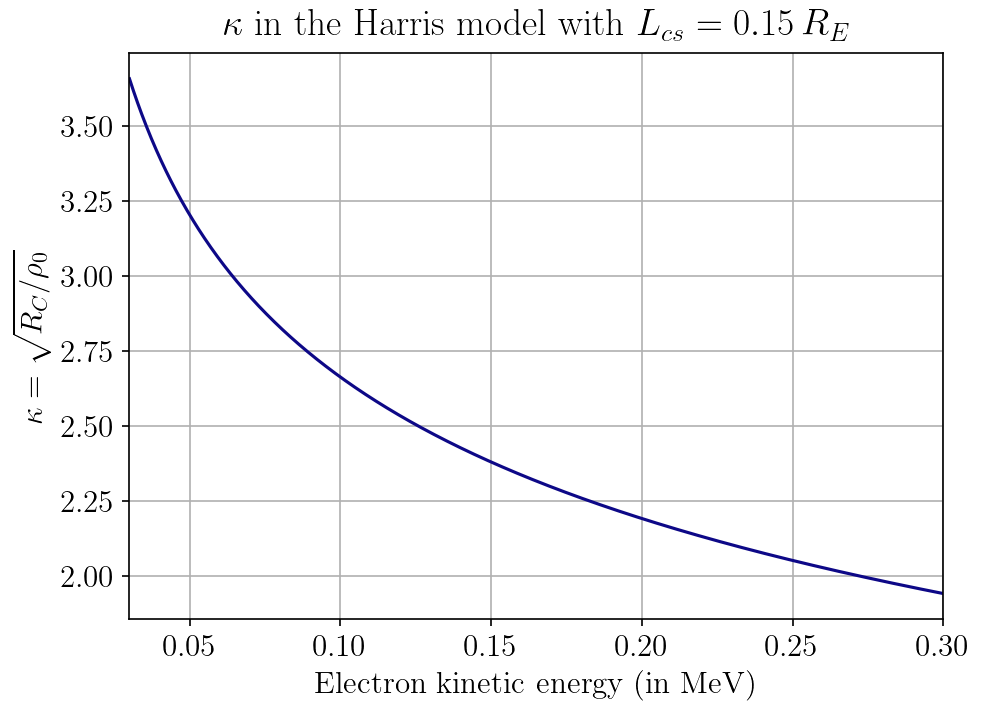

In [25]:
energies = np.linspace(30e3, 300e3, 1000)

def kappa_h(E):
    gamma = eV_to_J(E) / (sp.m_e * sp.c**2) + 1
    v = sp.c * np.sqrt(1 - 1 / gamma**2)
    return np.sqrt(np.abs(-sp.e) * sigma**2 * L_cs * b0x / (gamma * sp.m_e * v))

plt.figure(figsize=(7, 5))

plt.plot(energies * 1e-6, kappa_h(energies), c='C0')

plt.xlim([3e-2, 3e-1])
plt.xlabel('Electron kinetic energy (in MeV)')
plt.ylabel(r'$\kappa = \sqrt{R_C/ \rho_0}$')
plt.title(f'$\kappa$ in the Harris model with $L_{{cs}} = {L_cs / Re:.2f}\,R_E$')

plt.grid()
plt.show()

Using the methods of Young et al. (2002) and Young et al. (2008), we may plot the bounce-averaged equatorial pitch angle diffusion coefficient $\langle D_{\alpha_0\alpha_0}\rangle$. We may then estimate the particle lifetime using $\tau = 1/\langle D_{\alpha_0\alpha_0}(\alpha_{LC})\rangle$.

Approximate lifetime of 30 keV particles: 8.99e+06 s
Approximate lifetime of 100 keV particles: 4.84e+03 s
Approximate lifetime of 200 keV particles: 3.66e+02 s
Approximate lifetime of 300 keV particles: 1.25e+02 s


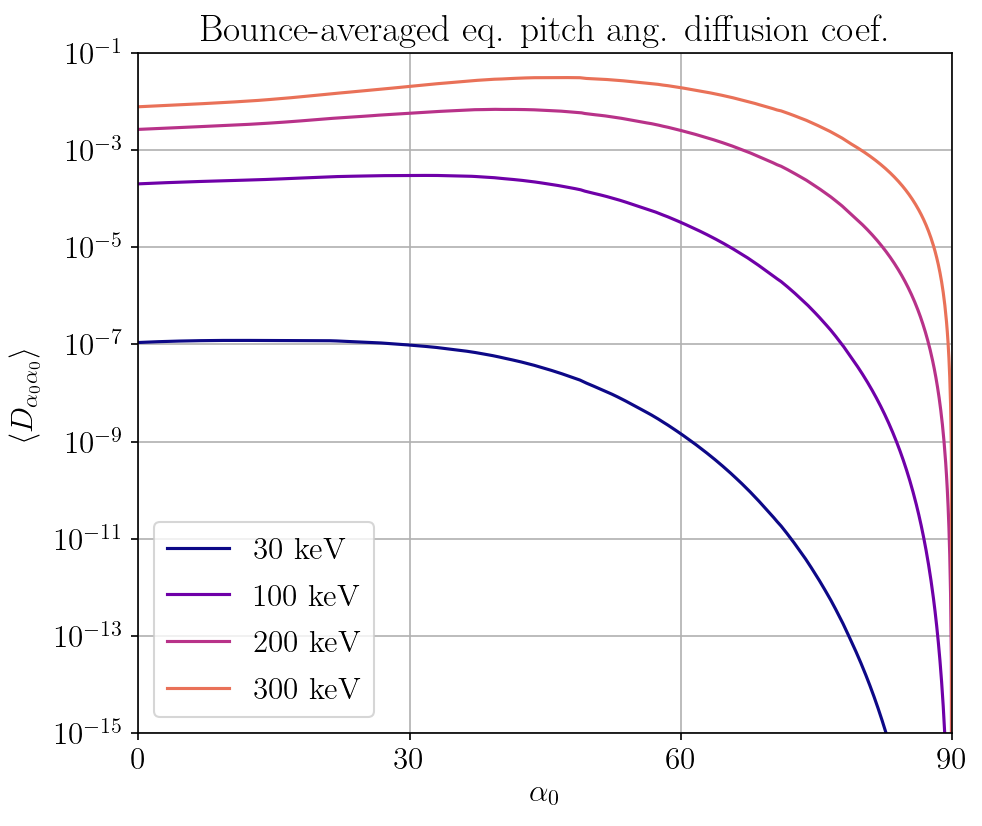

In [26]:
Es = [30, 100, 200, 300]
z1, z2 = zetas_harris(sigma)

steps = 1000
alpha_eqs = np.radians(np.linspace(1e-5, 90 - 1e-5, steps))

plt.figure(figsize=(7, 6))

for i in range(len(Es)):
    eps = epsilon_harris(Es[i] * 1e3, -sp.e, sp.m_e, b0x, sigma, L_cs)
    D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
    lifetime = 1 / D_aa(eps, z1, z2, eq_loss_cone_ang, T_alpha)
    print(f'Approximate lifetime of {Es[i]} keV particles: {lifetime:.2e} s')
    plt.semilogy(np.degrees(alpha_eqs), D_aas, c=f'C{3*i}', label=f'${Es[i]}$ keV')

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'$\alpha_0$')
plt.ylim([1e-15, 1e-1])
plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}\rangle$')
plt.title('Bounce-averaged eq. pitch ang. diffusion coef.')

plt.legend()
plt.grid()
plt.show()

We can do the same as above with the Tsyganenko model (as opposed to the Harris model).

Approximate lifetime of 30 keV particles: 5.09e+07 s
Approximate lifetime of 100 keV particles: 1.08e+04 s
Approximate lifetime of 200 keV particles: 5.73e+02 s
Approximate lifetime of 300 keV particles: 1.62e+02 s


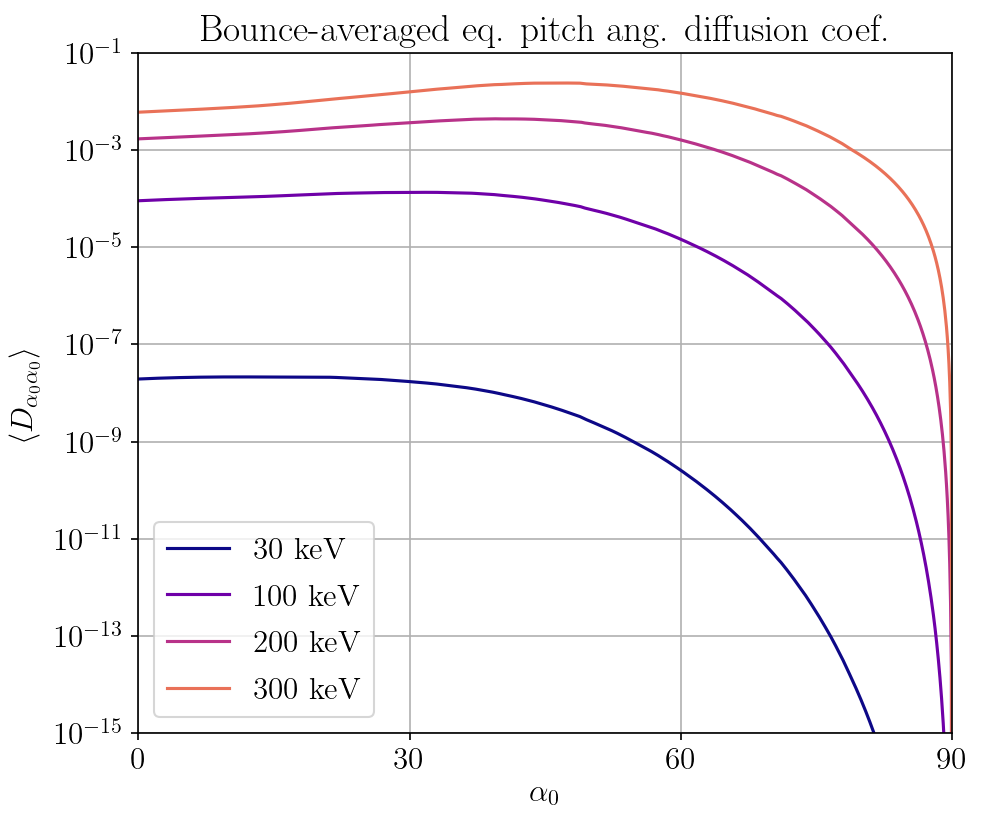

In [27]:
Es = [30, 100, 200, 300]
z1, z2 = zetas_general(b_field, L)
R_c = flc(b_field, rr[cs_ind])

steps = 1000
alpha_eqs = np.radians(np.linspace(1e-5, 90 - 1e-5, steps))

plt.figure(figsize=(7, 6))

for i in range(len(Es)):
    eps = epsilon_general(Es[i] * 1e3, -sp.e, sp.m_e, R_c, b0)
    D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
    lifetime = 1 / D_aa(eps, z1, z2, eq_loss_cone_ang, T_alpha)
    print(f'Approximate lifetime of {Es[i]} keV particles: {lifetime:.2e} s')
    plt.semilogy(np.degrees(alpha_eqs), D_aas, c=f'C{3*i}', label=f'${Es[i]}$ keV')

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'$\alpha_0$')
plt.ylim([1e-15, 1e-1])
plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}\rangle$')
plt.title('Bounce-averaged eq. pitch ang. diffusion coef.')

plt.legend()
plt.grid()
plt.show()

In [61]:
model = 0

In [63]:
s, r, b_spawn, pa = np.zeros(4)

if model == 0:
    # Full T04 + IGRF
    s = solver(zero_field(), b_field, higueracary)

    r = rr[cs_ind + 250]
    b_spawn = np.linalg.norm(b_field(r))
    pa = np.arcsin(np.sqrt(b_spawn / bm[cs_ind]) * np.sin(eq_loss_cone_ang))
elif model == 1:
    # Harris
    s = solver(uniform_field(1, np.array([0., 1., 0.])), b_field_h, higueracary)

    r = np.array([0., 0., -5 * Re])
    b_spawn = np.linalg.norm(b_field_h(r))
    pa = np.arcsin(np.sqrt(b_spawn / (sigma * b0x)) * np.sin(eq_loss_cone_ang))

In [48]:
# Populate

E = 300 # in keV

s.populate(
           1000,
           delta(r),
           delta(300 * E),
           delta(pa),
           np.linspace(0, 2 * np.pi, 1000),
           by_list=True
          )

100%|██████████| 1000/1000 [00:03<00:00, 310.72it/s]


In [12]:
# Solve

s.solve(1.5, 1e-4, 1e-3)

100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


In [13]:
s.save(f'{E}kev_case_study')

Saved file 300kev_t04_case_study.hdf5 containing 95.35 megabytes of information.


In [28]:
a = analyzer(f'{E}kev_case_study')

Loaded file 300kev_t04_case_study.hdf5 containing 116.36 megabytes of information.


In [29]:
pas = a.pitch_ang()
rs = a.position()
vs = a.velocity()
ms = a.mass()
qs = a.charge()

In [31]:
crossing_ind_avg = 0

for i in range(1000):
    if model == 0:
        crossing_ind = np.linalg.norm(rs[i, 0:500], axis=1).argmax()
        crossing_ind_avg += crossing_ind
    elif model == 1:
        crossing_ind = pas[i, :].argmax()
        crossing_ind_avg += crossing_ind

crossing_ind_avg /= 1000
crossing_ind_avg = int(round(crossing_ind_avg))

In [32]:
b_min = 1e10

if model == 0:
    for i in range(1000):
        r_temp, b_temp = guiding_center(rs[i, crossing_ind_avg], vs[i, crossing_ind_avg], b_field, ms[i], qs[i])
        b_min_maybe = np.linalg.norm(b_temp)
        if b_min_maybe < b_min:
            b_min = b_min_maybe
elif model == 1:
    b_min = sigma * b0x

In [68]:
gca_points = np.zeros((1000, 2, 3))

for i in range(1000):
    if model == 0:
        r, gca_points[i, 0] = guiding_center(rs[i, 0], vs[i, 0], b_field, ms[i], qs[i])
        r, gca_points[i, 1] = guiding_center(rs[i, crossing_ind_avg * 2], vs[i, crossing_ind_avg * 2], b_field, ms[i], qs[i])
    elif model == 1:
        r, gca_points[i, 0] = guiding_center(rs[i, 0], vs[i, 0], b_field_h, ms[i], qs[i])
        r, gca_points[i, 1] = guiding_center(rs[i, crossing_ind_avg * 2], vs[i, crossing_ind_avg * 2], b_field_h, ms[i], qs[i])

In [69]:
norm_mom_bs = b_min / np.linalg.norm(gca_points, axis=2)

In [70]:
sin_pas_start = np.sin(np.arccos(np.sum(vs[:, 0] * gca_points[:, 0], axis=1) / (np.linalg.norm(vs[:, 0], axis=1) * np.linalg.norm(gca_points[:, 0], axis=1))))
sin_pas_end = np.sin(np.arccos(np.sum(vs[:, crossing_ind_avg * 2] * gca_points[:, 1], axis=1) / (np.linalg.norm(vs[:, crossing_ind_avg * 2], axis=1) * np.linalg.norm(gca_points[:, 1], axis=1))))

In [71]:
mu_initial = 0.5 * norm_mom_bs[:, 0] * sin_pas_start**2
mu_final = 0.5 * norm_mom_bs[:, 1] * sin_pas_end**2

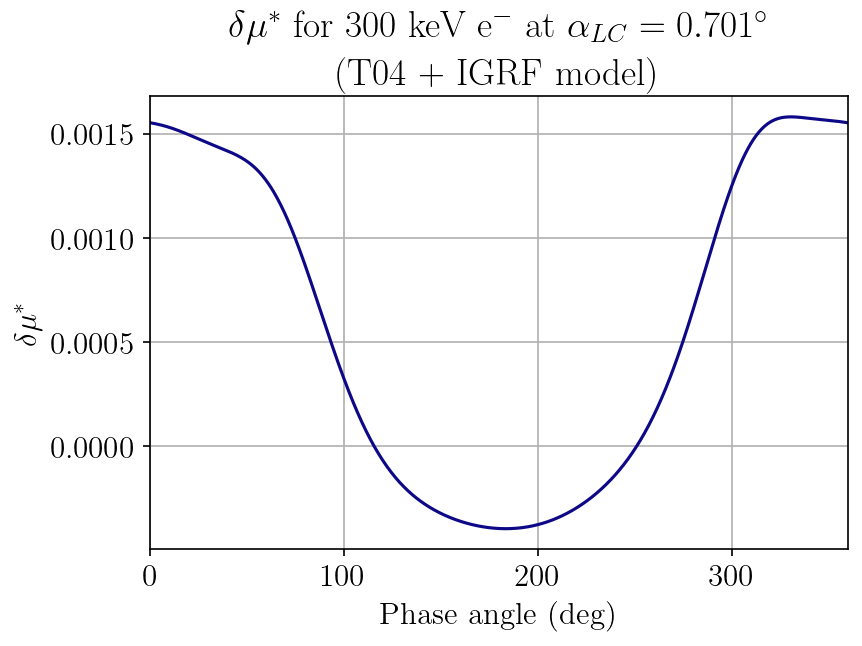

In [80]:
plt.plot(np.degrees(np.linspace(0, 2 * np.pi, 1000)), mu_final - mu_initial)
if model == 0:
    plt.title(f'$\delta\mu^*$ for ${E}$ keV e$^-$ at $\\alpha_{{LC}}={np.degrees(eq_loss_cone_ang):.3f}^\circ$\n(T04 + IGRF model)')
elif model == 1:
    plt.title(f'$\delta\mu^*$ for ${E}$ keV e$^-$ at $\\alpha_{{LC}}={np.degrees(eq_loss_cone_ang):.3f}^\circ$\n(Harris model)')
plt.ylabel(r'$\delta\mu^*$')
plt.xlabel('Phase angle (deg)')
plt.xlim([0, 360])
plt.grid()
plt.show()

In [58]:
dmu = mu_final - mu_initial
A_numerical = (np.amax(dmu) - np.amin(dmu)) / 2
print(f'The numerically found A value is: {A_numerical:.3e}')

The numerically found A value is: 9.881e-04


In [60]:
D_aa_num = A_numerical**2 / (2 * T_alpha(eq_loss_cone_ang) * np.sin(eq_loss_cone_ang)**2 * np.cos(eq_loss_cone_ang)**2)
lifetime_num = 1 / D_aa_num
print(f'The numerically found lifetime is: {lifetime_num:.3e} s')

The numerically found lifetime is: 3.299e+02 s
